In [50]:
%matplotlib widget

In [51]:
import numpy as np
import scipy as sp
from scipy import integrate
import matplotlib.pyplot as plt
import astropy as ap
import astropy.table as at
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import pandas as pd


cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

### Austen Fourkas

The point of this assignment is to:
- to make sure you have a sense of fluxes, magnitudes and distances as a function of redshift
- get familiar with drawing random numbers from a distribution, making cuts on your data
- modeling in the presence of systematic effects and the resulting biases you'll encounter

# Q1. The $k$-correction in the sub-mm and the optical (60 pts)

You know how to calculate the flux synthetically in some band, but what about comparing the flux of the same class of objects at different redshifts. Necessarily, you'll have to compare the rest-frame flux with the observer frame flux further in the red at some redshift $z$ because the Universe is expanding and frequency of photons is shifting. 

To do this, you need the "$k$-correction" which is nicely summarized in Hogg et al. 2002: https://arxiv.org/abs/astro-ph/0210394
(You might start by looking at Eqn. 12, and comparing it to the synthetic integrals for the flux you implemented in Homework 1)

As we discussed in class (or as you might know if you've listened to a talk from Prof. Joaquin Vieira) galaxies have an interesting effect where the flux density $F_\nu$ from about 250$\mu m$ becomes roughly constant over a large range in redshift because you climb the Rayleigh-Jeans tail as you increase redshift, which compensates for the decrease in the flux density because of increasing distance. In the optical, you have no such luck, and indeed, depending on the class of galaxy, the $k$-correction means that galaxies in a fixed observer band might seem even fainter than you might expect from the inverse square law. 

In particular, the $k$-correction goes negative. 

In this problem, you'll implement the k-correction (reuse the code from HW1 and simplify Eqn 12).

I've included an SED of a galaxy ```aless_average_seds.dat``` from Elisabete de Cunha (you can read about it here: http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates.html) with this homework. The columns are wavelength (in microns), average $F_\nu$ (in mJy), and upper and lower credible regions on the flux density.

Your mission is to make three plots (15 points each for the plot):

- Fig 1. should plot the flux density in mJy of this SED as a function of redshift (see here: https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html) in common bands - assume perfectly rectangular bands with a fixed 3  micron bandwidth around the central wavelengths shown in the above figure. (Hint: this doesn't need you to actually compute the $k$-correction explicitly yet, but you will need to be careful about units and show that you know how to redshift and dim an SED). Evaluate this on a grid of redshift from $z$=1 to $z$=8 (inclusive) with $\Delta z$=0.25 spacing.

- Fig 2. should plot the flux density (in mJy) of the SED as a function of wavelength in microns (see the 2nd animation here: http://www.as.utexas.edu/~cmcasey/animated.html) over the same redshift grid (you can use $\Delta z$=0.50 to make it less cluttered if you like) and overplot the sub-mm bands for BICEP2 (http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse&gname=BICEP&gname2=BICEP2&asttype=) 
  
- Fig 3. should plot the $k$-correction (in magnitudes) itself for LSST giy bands as a function of redshift between $z$=0. and $z=2$ in $\Delta z$=0.01 steps (you can use whatever linestyle you like to join the lines, but make sure you use a different color for each of the observer frames). The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength to the observer frame filter's effective wavelength at each redshift. If there is no band that maps well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame filter) stop computing the $k$-correction for that filter. 

Hint: Astropy has a units module to help convert between different units and an equivalencies option particularly to convert between wavelengths and frequencies (https://docs.astropy.org/en/stable/units/equivalencies.html). You can try to do it by hand, but if you mess it up, you'll get rubbish. It also has a cosmology module to compute luminosity distance as a function of redshift - you can assume a Flat $\Lambda$CDM cosmology. 

### This is not actually all that much code if you break it into a few functions.

In [52]:
## read in data
data = at.Table.read(
    "aless_average_seds.dat",
    format="ascii",
    names=["wave", "fnu", "fnu_bright", "fnu_faint"],
    data_start=1,
)

## apply units
data["wave"] = data["wave"] * u.micron
data["fnu"] = data["fnu"] * u.mJy
data["fnu_bright"] = data["fnu_bright"] * u.mJy
data["fnu_faint"] = data["fnu_faint"] * u.mJy

## read in filters
filter_centers = [220, 150, 95]
filters = {}
for l in filter_centers:
    data_in = np.loadtxt(f"BICEP/BICEP_{l}.dat")
    filters[f"{l}_lambda"] = data_in[:, 0] * u.angstrom
    filters[f"{l}_trans"] = data_in[:, 1]

In [53]:
## Z + l arrays
z_array_25 = np.arange(1, 8, 0.01)
z_array_50 = np.arange(1, 8.1, 0.5)
z_array_001 = np.arange(0, 2, 0.001)
l_array = [150, 200, 250, 350, 450, 500, 850, 1100, 1400, 2100, 3000, 5000]

In [54]:
## functions
def redshift_SED(l, f, z):
    d1 = 10 * u.pc
    d2 = cosmo.luminosity_distance(z).to(u.pc)
    d_ratio = (d1 / d2) ** 2

    l_z = l * (1 + z)
    f_z = f * d_ratio * (1 + z)

    return l_z, f_z


def make_band(center, width):
    lambda_array = np.linspace(center - width, center + width, 100000)
    trans_array = np.ones(100000)
    return lambda_array, trans_array


def interp_bands(l, f, band_l, band_t):

    # sed over band
    f_interp = np.interp(band_l, l, f)

    # integrate flux and account for band
    nu = (3e14) / band_l
    z_flux = integrate.simpson(
        y=(nu**2 / (3e14) * f_interp * band_t * band_l), x=band_l
    )
    band_total = integrate.simpson(y=band_t * band_l, x=band_l)

    # final
    final_val = z_flux / band_total
    return final_val

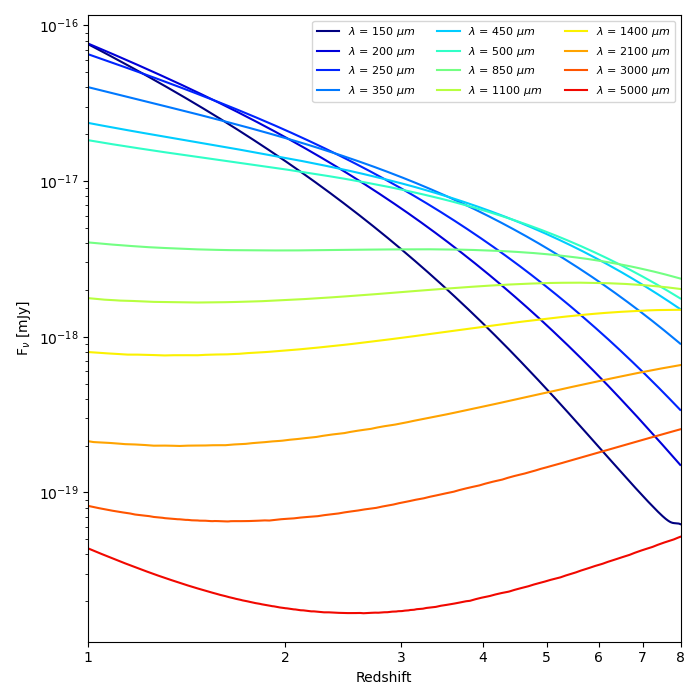

In [55]:
## part a test
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# colors
color = plt.cm.jet(np.linspace(0, 0.9, len(l_array)))

# data
for i in range(len(l_array)):
    final_flux_array = np.zeros(len(z_array_25))
    for z in range(len(z_array_25)):
        lambda_z, flux_z = redshift_SED(data["wave"], data["fnu"], z_array_25[z])
        lambda_band, trans_band = make_band(l_array[i], 3)
        final_flux = interp_bands(lambda_z, flux_z, lambda_band, trans_band)
        final_flux_array[z] = final_flux * l_array[i] ** 2 / (3e14)
    ax.plot(
        z_array_25,
        final_flux_array,
        label=rf"$\lambda$ = {l_array[i]} $\mu m$",
        color=color[i],
    )

# extras
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1, 8])
ax.legend(prop={"size": 8}, ncol=3)
ax.set_xlabel("Redshift")
ax.set_ylabel(r"F$_{\nu}$ [mJy]")
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8"])

plt.tight_layout()
plt.show()

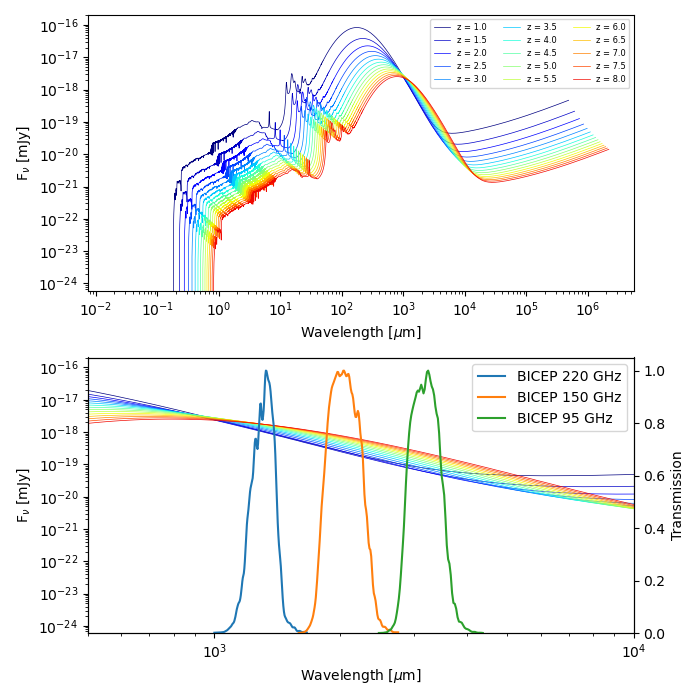

In [62]:
## part b
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax3 = ax2.twinx()
color = plt.cm.jet(np.linspace(0, 0.9, len(z_array_50)))

# data
for z in range(len(z_array_50)):
    lambda_z, flux_z = redshift_SED(data["wave"], data["fnu"], z_array_50[z])
    ax1.plot(
        lambda_z, flux_z, linewidth=0.5, label=f"z = {z_array_50[z]}", color=color[z]
    )
    ax2.plot(
        lambda_z, flux_z, linewidth=0.5, label=f"z = {z_array_50[z]}", color=color[z]
    )

# (DL_pt2[z] ** 2) *
# filters
for l in filter_centers:
    ax3.plot(
        filters[f"{l}_lambda"].to(u.micron),
        filters[f"{l}_trans"],
        label=f"BICEP {l} GHz",
    )

## ax1 extras
ax1.legend(prop={"size": 6}, ncol=3)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"Wavelength [$\mu$m]")
ax1.set_ylabel(r"F$_{\nu}$ [mJy]")

## ax2 extras
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlim([5e2, 1e4])
ax2.set_xlabel(r"Wavelength [$\mu$m]")
ax2.set_ylabel(r"F$_{\nu}$ [mJy]")

## ax3 extras
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Transmission")
ax3.legend()

plt.tight_layout()
plt.show()

In [63]:
## part 3 :(
def f_lambda_convert(l, f):
    f_conv = (3e14 / (l**2)) * f
    return f_conv


def g_AB(l):
    nu = (3e14) / l
    g_conv = (nu**2 / (3e14)) * (3631)
    return g_conv

/Users/afourkas/miniconda3/envs/503/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/afourkas/miniconda3/envs/503/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/afourkas/miniconda3/envs/503/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:690: RuntimeWarning: invalid value encountered in scalar subtract
  result += alpha*y[slice1] + beta*y[slice2] - eta*y[slice3]
/var/folders/zr/h9ws520j7x147p8l8znhwm800000gn/T/ipykernel_7742/2950108559.py:76: RuntimeWarning: invalid value encountered in multiply
  LSST_table[f"{R}_wave"] * SED_obs_band_nu * LSST_table[f"{R}_trans"]
/var/folders/zr/h9ws520j7x147p8l8znhwm800000gn/T/ipykernel_7742/2950108559.py:97: RuntimeWarning: invalid value encountered in 

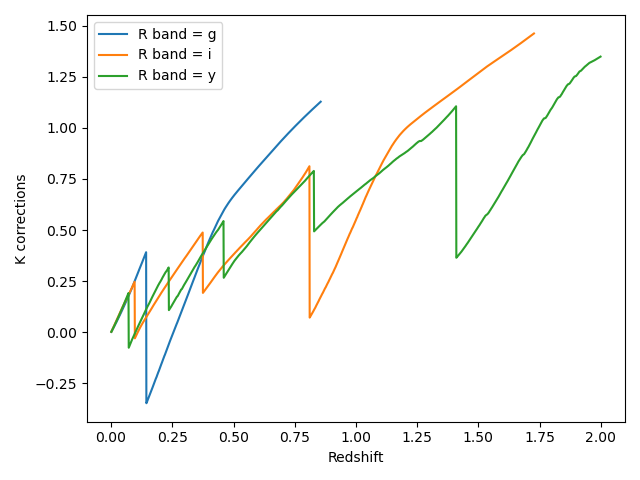

In [64]:
# oh my god it worked
# wavelength to frequency
def l_to_nu(l):
    nu = (3e14) / l
    return nu


R = ["g", "i", "y"]

LSST_bands = ["u", "g", "r", "i", "z", "y"]
LSST_table = {}
for b in LSST_bands:
    data_in = np.loadtxt(f"LSST/LSST_LSST.{b}_filter.dat")
    LSST_table[f"{b}_wave"] = data_in[:, 0] * 1e-4
    LSST_table[f"{b}_trans"] = data_in[:, 1]

fig, ax = plt.subplots(1, 1)

for R_i, R in enumerate(R):
    K_list_2 = []
    for i_z, z in enumerate(z_array_001):

        diff_array = np.zeros((len(LSST_bands)))
        R_wave_shift = LSST_table[f"{R}_wave"] / (1 + z)
        R_end = R_wave_shift[-1]
        R_start = R_wave_shift[0]

        for b_i, band in enumerate(LSST_bands):
            band_end = LSST_table[f"{band}_wave"][-1]
            band_start = LSST_table[f"{band}_wave"][0]

            end_diff = abs(R_end - band_end)
            start_diff = abs(R_start - band_start)
            total_diff = start_diff + end_diff
            diff_array[b_i] = total_diff

        min_index = np.where(diff_array == np.amin(diff_array))[0][0]
        band_select = LSST_bands[min_index]

        if R_end < LSST_table[f"{band_select}_wave"][0]:
            continue
        else:

            # redshift SED
            z_lambda, z_flux = redshift_SED(data["wave"], data["fnu"], z)

            # get SED in OBSERVER BAND
            SED_obs_band = np.interp(
                LSST_table[f"{R}_wave"], z_lambda, z_flux, left=0, right=0
            )
            SED_obs_band_nu = f_lambda_convert(LSST_table[f"{R}_wave"], SED_obs_band)

            # get SED in REST BAND
            SED_backshift = np.interp(
                LSST_table[f"{band_select}_wave"] * (1 + z),
                z_lambda,
                z_flux,
                left=0,
                right=0,
            )
            SED_backshift_nu = f_lambda_convert(
                LSST_table[f"{band_select}_wave"], SED_backshift
            )

            # AB REST BAND
            g_AB_rest_nu = g_AB(LSST_table[f"{band_select}_wave"])

            # AB OBSERVED BAND
            g_AB_obs_nu = g_AB(LSST_table[f"{R}_wave"])

            # rest

            ## integral 1
            int_one = integrate.simpson(
                y=(
                    LSST_table[f"{R}_wave"] * SED_obs_band_nu * LSST_table[f"{R}_trans"]
                ),
                x=LSST_table[f"{R}_wave"],
            )

            int_two = integrate.simpson(
                y=(
                    LSST_table[f"{band_select}_wave"]
                    * g_AB_rest_nu
                    * LSST_table[f"{band_select}_trans"]
                ),
                x=LSST_table[f"{band_select}_wave"],
            )

            int_three = integrate.simpson(
                y=(LSST_table[f"{R}_wave"] * g_AB_obs_nu * LSST_table[f"{R}_trans"]),
                x=LSST_table[f"{R}_wave"],
            )

            int_four = integrate.simpson(
                y=(
                    LSST_table[f"{band_select}_wave"]
                    * (SED_backshift_nu)
                    * LSST_table[f"{band_select}_trans"]
                ),
                x=LSST_table[f"{band_select}_wave"],
            )
            K = -2.5 * np.log10(
                (1 / (1 + z)) * (int_one * int_two) / (int_three * int_four)
            )
            K_list_2.append(K)
            # print(band_select, R, z, int_one, int_two, int_three, int_four, K)
    ax.plot(z_array_001[0 : len(K_list_2)], K_list_2, label=f"R band = {R}")

# plot extras
ax.set_ylabel("K correction")
ax.set_xlabel("Redshift")
ax.legend()

plt.tight_layout()
plt.show()

# Q2 - Supernovae and $H_0$ (40 pts - 10 per part)

For this simulation, we will generate a sample of type Ia supernovae. These are special as they have similar intrinsic brightness, so that their apparent flux can be used to measure how far away they are. If their redshift is also measured, the measurements can be used to calculate the expansion rate of the Universe, or Hubble's constant.

We want to understand *how* brightness limits affect the use of type Ia supernovae observations in the measurement of the Hubble constant, $H_0$. To do so, we will use Monte Carlo computations to generate a set of simulated data. 

A subtle effect occurs in this measurement, called Malmquist bias, that can affect the result. The effect is caused by the range of apparent brightness for supernova. Supernova in our simulation have an absolute magnitude of M=-19. 

Assume the supernova have a scatter about their absolute magnitude of approximately 1 magnitude (this is much too large, but it is to exaggerate the effect we'll see). 1-2m class survey telescopes will detect objects as faint as m=21 in about a minute of exposure - treat this is as their reliable detection limit - i.e. sources <= 21 are detected 100% of the time. Sources > 21 are detected with 0% efficiency. This is obviously unrealistic, but it'll suffice for now.

The limiting magnitude corresponds to a distance modulus m-M=5 log10(d/10 pc) of 40, which suggests that supernova can be seen at least as far away as 1000 Mpc. 

(We will assume that over this distance, the SED of SNe Ia are approximately constant so we can happily neglect the $k$-correction, so you will not murder me after you have suffered through Q1)

Assume supernova are formed uniformly throughout *a sphere* with radius r=2500 Mpc. In the data generation part of the simulation, assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, and standard deviation of 600 km/s. (Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing)

1. Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. Have the program generate the true distances, $d$, to the supernovae. Calculate the mean distance for the supernovae.

2. Now assume each supernovae has a brightness governed by M = -19 +G(1) where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. Calculate the apparent magnitude of each supernovae using the distance generated in part (1). If m>21, assume the object is too faint to detect and reject it from the sample. Create a plot of magnitude versus distance for all the supernovae. Write out the *average* magnitudes of the original sample and the detected sample. 

3. Generate the velocities (both recession and peculiar) as described earlier. Generate an observed distance ($d'$) by using its apparent magnitude and Hubble’s law, with the *assumption* that the supernova has an absolute magnitude (M) of -19. Plot the observed distance on the x-axis and total velocity on the y-axis and compare it to the true distance. Explain the effect of the observing limit on the resulting sample. 

4. Calculate $H_0$ by fitting a line to all your detected points. Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size. 

Q4 Answer:
The established limiting magnitude stops detections from going beyond 1000 Mpc, meaning that a proper H0 fit cannot be accomplished. The limiting magnitude provides a large bias away from the established value of H0, and does not seem to dissipate with higher and higher n values. As for pecular velocity, it seems to make an impact at all distances, as the H0 fit does not exactly reproduce the established H0 value. These effects could be accounted for through more sensitive instruments, which would allow the magnitude barrier to be surpassed and the impact of pecular velocities to be reduced.

In [66]:
## make all functions
cosmo = FlatLambdaCDM(H0=72, Om0=0.3)


## function
def make_redshifts(n):
    zs = np.cbrt(np.random.uniform(0, 0.46112**3, n))
    return zs


def make_z_distances(zs):
    distances = cosmo.luminosity_distance(zs)
    return distances


def make_magnitudes(b, n):
    magnitudes = np.zeros(n)
    for i in range(n):
        random_val = np.random.normal(0, 1)
        mag_val = b + random_val
        magnitudes[i] = mag_val
    return magnitudes


def convert_magnitudes(d, M):
    m = M + (5 * (np.log10(d.value * 1e6))) - 5
    return m


def crop_magnitudes(m, d, L):
    crop_m_lower = m[m <= L]
    crop_m_upper = m[m > L]

    crop_d_lower = d[m <= L]
    crop_d_upper = d[m > L]
    return crop_m_lower, crop_m_upper, crop_d_lower, crop_d_upper


def make_velocity(d, H):
    v_z = H * d
    v_peculiar = np.random.normal(0, 600, len(d))
    v_final = v_z + v_peculiar
    return v_final


def make_observed_distance(M, m):
    d = (10 ** ((m - M + 5) / 5)) / 1e6
    return d


def lsq_function(x, a):
    result = a * x
    return result

-------------------------------------------
n = 100
Average distance = 1787.02 Mpc
Average magnitude (full sample) = 22.18
Average magnitude (detected sample) = 20.29
-------------------------------------------
n = 1000
Average distance = 1801.87 Mpc
Average magnitude (full sample) = 22.20
Average magnitude (detected sample) = 20.11
-------------------------------------------
n = 10000
Average distance = 1803.07 Mpc
Average magnitude (full sample) = 22.15
Average magnitude (detected sample) = 20.16


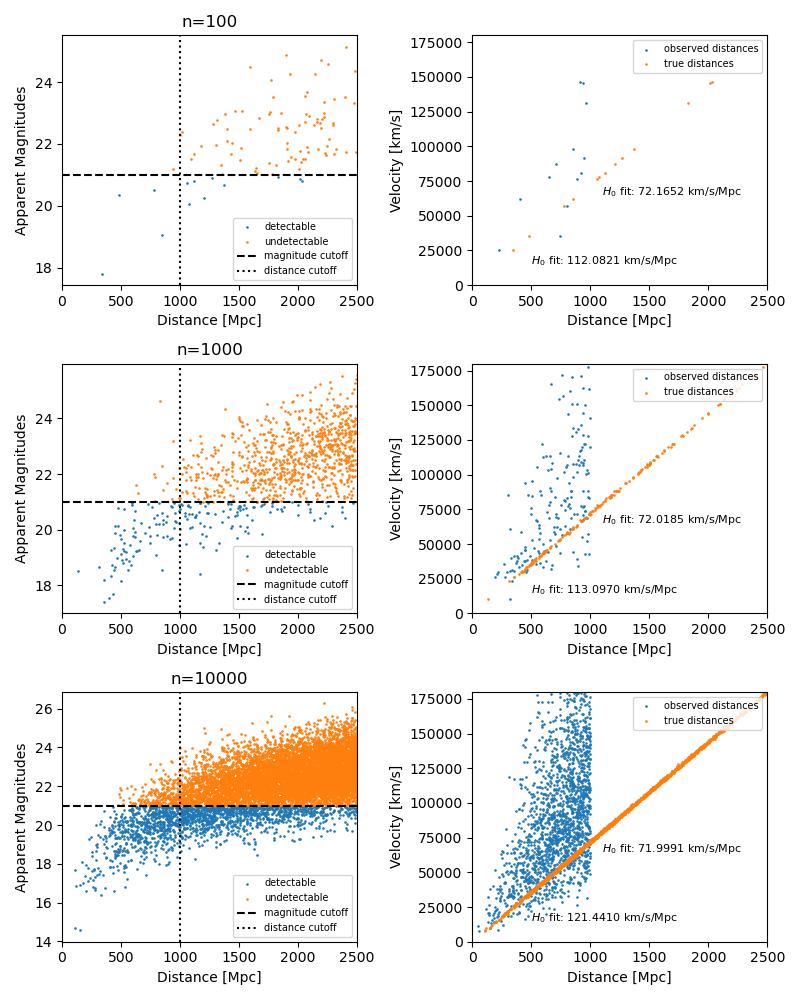

In [80]:
## constants
r = 2500
M = -19
L = 21
H = 72
n_array = [100, 1000, 10000]


## total function
def total_function(n, M, L, H):
    redshifts = make_redshifts(n)
    distances = make_z_distances(redshifts)
    magnitudes = make_magnitudes(M, n)
    absolutes = convert_magnitudes(distances, magnitudes)
    m_lower, m_upper, d_lower, d_upper = crop_magnitudes(absolutes, distances, L)
    lower_velocity = make_velocity(d_lower.value, H)
    observed_distances = make_observed_distance(M, m_lower)
    fit_1 = curve_fit(lsq_function, observed_distances, lower_velocity)
    fit_2 = curve_fit(lsq_function, d_lower, lower_velocity)
    return (
        distances,
        absolutes,
        m_lower,
        m_upper,
        d_lower,
        d_upper,
        observed_distances,
        lower_velocity,
        fit_1,
        fit_2,
    )


## plotting
fig = plt.figure(figsize=(8, 10))
gs = fig.add_gridspec(3, 2)
axs = gs.subplots(sharex=False, sharey=False)
axs = axs.flatten()

## looping
for i in range(len(n_array)):
    n = n_array[i]
    d, m, ml, mu, dl, du, od, lv, f1, f2 = total_function(n, M, L, H)

    # left plots
    axs[2 * i].scatter(dl, ml, s=0.75, label="detectable")
    axs[2 * i].scatter(du, mu, s=0.75, label="undetectable")
    axs[2 * i].axhline(21, 0, 1, c="k", ls="--", label="magnitude cutoff")
    axs[2 * i].axvline(1000, 0, 1, c="k", ls="dotted", label="distance cutoff")

    # extras
    axs[2 * i].legend(prop={"size": 7}, loc=4)
    axs[2 * i].set_xlim([0, 2500])
    axs[2 * i].set_xlabel("Distance [Mpc]")
    axs[2 * i].set_ylabel("Apparent Magnitudes")
    axs[2 * i].set_title(f"n={n_array[i]}")

    # right plots
    axs[(2 * i) + 1].scatter(od, lv, s=0.75, label="observed distances")
    axs[(2 * i) + 1].scatter(dl, lv, s=0.75, label="true distances")

    # extras
    axs[(2 * i) + 1].set_xlim([0, 2500])
    axs[(2 * i) + 1].set_ylim([0, 180000])
    axs[(2 * i) + 1].set_xlabel("Distance [Mpc]")
    axs[(2 * i) + 1].set_ylabel("Velocity [km/s]")
    axs[(2 * i) + 1].text(
        500, 15000, rf"$H_{0}$ fit: {f1[0][0]:.4f} km/s/Mpc", fontsize=8
    )
    axs[(2 * i) + 1].text(
        1100, 65000, rf"$H_{0}$ fit: {f2[0][0]:.4f} km/s/Mpc", fontsize=8
    )
    axs[(2 * i) + 1].legend(prop={"size": 7}, loc=1)

    # prints
    print("-------------------------------------------")
    print(f"n = {n_array[i]}")
    print(f"Average distance = {np.mean(d):.2f}")
    print(f"Average magnitude (full sample) = {np.mean(m):.2f}")
    print(f"Average magnitude (detected sample) = {np.mean(ml):.2f}")

## final
plt.tight_layout()
plt.show()

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 1 at Noon!